Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp
from mne.stats import fdr_correction
import matplotlib.pyplot as plt
from systole.detection import oxi_peaks, rr_artefacts
from systole.correction import correct_peaks
from systole.utils import heart_rate, to_epochs
from systole.plotting import plot_subspaces
import pingouin as pg

In [2]:
path = os.path.join(os.getcwd(), 'data', 'task')
subjects = [f for f in os.listdir(path) if len(f) == 5]
filename = path + '/{nSub}/{nSub}_Aro_{arousal}_Val_{valence}_Learn_{learningTime}_Block_{block}.txt'  # Template for signal files

In [9]:
for nSub in subjects:
    
    # Find files name
    for file in os.listdir(os.path.join(path, nSub)):
        if file.endswith(".txt") & file.startswith('Subject') & ('Block' not in file):
            df = pd.read_csv(os.path.join(path, nSub, file), na_values=['Nan'])
        elif file.endswith('9.npy'):
            nSub2 = file[:len(file) - 5]

    # Start loop
    for val in ['High', 'Low']:

        for aro in ['High', 'Low']:

            for learningTime in [30, 60, 90]:

                # Get block numbers
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                nBlock = int(this_df.nBlock.iloc[0])
                oxi = np.load(os.path.join(path, nSub, nSub2 + str(nBlock) + '.npy'), allow_pickle=True)[0]
                triggers = np.load(os.path.join(path, nSub, nSub2 + str(nBlock) + '.npy'), allow_pickle=True)[1][:-1]
                time = np.arange(0, len(oxi))/75

                file_df = pd.DataFrame({'time': time, 'signal':oxi, 'triggers':triggers})
                file_df.to_csv(filename.format(nSub=nSub, arousal=aro, valence=val, learningTime=learningTime, block=nBlock))

**Drop participants**

In [10]:
# For bad signal
reject = ['11141']

# Based on behavioural results
reject.extend(['11119', '11124', '11138', '11131', '47617'])

In [11]:
subjects = [f for f in subjects if f not in reject]

# Extract heart rate

In [12]:
def plot_epochs(epoch, triggers, peaks, time, new_time, hr, outliers, figure_name):
    """Plot epochs and artefact rejection.
    """

    fig = plt.figure(figsize=(13, 8))
    ax1 = plt.subplot2grid((2,3), (0,0), colspan=4)
    # Triggers
    for i in np.where(np.asarray(triggers)==2)[0]/75:
        ax1.axvline(x=i, linestyle='--', color='k', linewidth=1)
    # Rejected epochs
    for i in np.where(triggers==2)[0][np.isnan(epoch.mean(1))]:
        ax1.axvspan((i/75), (i/75)+6, alpha=0.2, color='gray')
    ax1.plot(time[peaks][1:], 60000/np.diff(np.where(peaks)[0]), 'o', color='#0b559f', markersize=3, alpha=0.8)
    ax1.plot(new_time, hr, '--', color='gray', linewidth=1)
    ax1.plot(time[peaks][1:][outliers], 60000/np.diff(np.where(peaks)[0])[outliers], 'ro', markersize=6, alpha=0.8)
    ax1.set_ylim(40, 120)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('BPM')
    ax1.set_title('Heart rate time serie')

    ax2 = plt.subplot2grid((2,3), (1,0))
    ax3 = plt.subplot2grid((2,3), (1,1))

    plot_subspaces(np.diff(np.where(peaks)[0]), ax=[ax2, ax3])

    ax4 = plt.subplot2grid((2,3), (1,2))
    for i in range(len(epoch)):
        ax4.plot(np.arange(tmin, tmax, 1/75), epoch[i], color='#55a868', alpha=0.2)
    ax4.plot(np.arange(tmin, tmax, 1/75), np.nanmean(epoch, axis=0), color='#55a868', linewidth=3)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('BPM')
    ax4.set_ylim(-15, 15)
    ax4.set_title('Evoked response')

    plt.tight_layout()
    plt.savefig(figure_name, dpi=300)
    plt.close(fig)

In [13]:
def extract_epochs(signal, triggers, valence, arousal, learningTime, nSub, tmin, tmax, draw_figure=False, figure_name=None):
    """This function will find peaks in signal, reject artefacts and epoch the raw data.
    If draw_figure is True, will also create a report figure."""

    # Find peaks
    signal, peaks = oxi_peaks(signal, noise_removal=False)
    
    # Correct extra and missed peaks
    peaks_correction = correct_peaks(peaks)
    peaks = peaks_correction['clean_peaks']

    # Extract instantaneous heartrate
    hr, time = heart_rate(peaks, sfreq=1000, unit='bpm', kind='previous')
    hr = gaussian_filter1d(hr, sigma=100)

    # Interpolate HR to 75 Hz
    f = interp1d(time, hr, fill_value="extrapolate")
    new_time = np.arange(0, time[-1], 1/75)
    hr = f(new_time)

    # Outliers detection
    artefacts = rr_artefacts(np.diff(np.where(peaks)[0]))
    outliers = artefacts['ectopic'] | artefacts['short'] | artefacts['long'] | artefacts['extra'] | artefacts['missed']
        
    # Create bads vector
    reject = np.zeros(len(peaks))
    for i in np.where(outliers)[0]:
        reject[np.where(peaks)[0][i-1]:np.where(peaks)[0][i+1]] = 1
        
    # Interpolate HR to 75 Hz
    f = interp1d(time, reject, fill_value="extrapolate")
    new_time = np.arange(0, time[-1], 1/75)
    reject = f(new_time)

     # Epoching
    epoch = to_epochs(hr, triggers, sfreq=75, event_val=2, tmin=tmin, tmax=tmax, apply_baseline=(0), reject=reject)
    
    if draw_figure:
        plot_epochs(epoch=epoch, triggers=triggers, peaks=peaks, time=time, new_time=new_time, hr=hr,
                   outliers=outliers, figure_name=figure_name)

    return epoch

In [16]:
tmin, tmax = -1, 6
final_df = pd.DataFrame([])
for nSub in subjects:

    output_dir = os.path.join(os.getcwd(), 'Figures/Reports_Python/', nSub)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    figure_name = output_dir + '/Valence{valence}_Arousal{arousal}_Learning{learningTime}.png'  # Template for report

    
    # Import behavioural data
    df = pd.read_csv(os.path.join(path, nSub, 'Subject_{}.txt'.format(nSub)), na_values=['Nan'])

    # Loop through conditions
    for val in ['High', 'Low']:
        for aro in ['High', 'Low']:
            for learningTime in [30, 60, 90]:

                # Filter for condition
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                nBlock = this_df.nBlock.iloc[0]  # Get block numbers
                
                # Import pulse oximeter recording
                signal_file = filename.format(nSub=nSub, arousal=aro, valence=val, learningTime=learningTime, block=int(nBlock))
                signal_df = pd.read_csv(signal_file)
                
                # Remove NaN, fast and slow RT
                drop = ((this_df.RT.isnull() | this_df.Confidence.isnull()) | 
                        (this_df.RT < .1) | (this_df.RT > (this_df.RT.median() + (3 * this_df.RT.std()))))    

                # Extract epoch and plot artefact rejection
                epoch = extract_epochs(signal_df.signal.to_numpy(),
                                       signal_df.triggers.to_numpy(),
                                       valence=val, arousal=aro, learningTime=learningTime, nSub=nSub,
                                       tmin=tmin, tmax=tmax, draw_figure=True,
                                       figure_name=figure_name.format(valence=val, arousal=aro, learningTime=learningTime));
            
                # Drop no response and artefact trials
                drop = drop | np.isnan(epoch.mean(axis=1))
                epoch = epoch[~drop, :]
                
                # Downsample
                epoch = epoch[:, ::15]

                final_df = final_df.append(pd.DataFrame({'Arousal':aro,
                                                         'Valence': val,
                                                         'Keep': len(epoch)/50,
                                                         'LearningTime': learningTime,
                                                         'Time': np.arange(tmin, tmax, 1/5),
                                                         'Subject': nSub,
                                                         'BPM': np.nanmean(epoch, axis=0)}))

In [17]:
final_df.to_csv(os.path.join(os.getcwd(), 'evoked.txt'))

In [3]:
final_df = pd.read_csv(os.path.join(os.getcwd(), 'evoked.txt'))

# Plot results

Compute % trial rejection.

In [4]:
1 - final_df.Keep.mean(), (1 - final_df.Keep).std()

(0.18229885057474338, 0.11499298742489612)

## Subject level

In [5]:
for nSub in subjects:
    df = final_df[final_df.Subject==int(nSub)].copy()

    # Plot results
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    sns.lineplot(data=df, x='Time', y='BPM', hue='Valence', style='Arousal', ci=68, palette=['steelblue', 'firebrick'], ax=axs)
    axs.axhline(y=0, linestyle='--', color='gray')
    axs.axvline(x=0, linestyle='--', color='k')
    axs.set_ylim(-6, 6)
    axs.set_ylabel('delta BPM')
    axs.set_title('Evoked responses')

    plt.tight_layout()
    dirName = os.path.join(os.getcwd(), 'Figures/Reports_Python/', nSub)
    plt.savefig(dirName + '/Evoked.png', dpi=300)
    plt.close(fig)

## Main effects

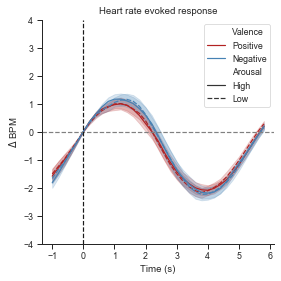

In [6]:
tmin, tmax = -1, 6
sns.set_context('paper')
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

df = final_df.copy().groupby(['Subject', 'Valence', 'Arousal', 'Time'], as_index=False).mean()
df.Valence = df.Valence.replace(['Low', 'High'], ['Negative', 'Positive'])

sns.lineplot(data=df, x='Time', y='BPM', hue='Valence', style='Arousal', ci=68, palette=['firebrick', 'steelblue'], ax=axs)
axs.axhline(y=0, linestyle='--', color='gray')
axs.axvline(x=0, linestyle='--', color='k')
axs.set_ylim(-4, 4)
axs.set_ylabel('$\Delta$ BPM')
axs.set_xlabel('Time (s)')
axs.set_title('Heart rate evoked response')

sns.despine()
plt.tight_layout()
dirName = os.path.join(os.getcwd(), 'Figures/')
plt.savefig(dirName + '/Evoked.svg', dpi=300)

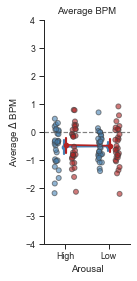

In [7]:
tmin, tmax = -1, 6
sns.set_context('paper')
fig, axs = plt.subplots(1, 1, figsize=(2, 4))

df = final_df.copy()[final_df.Time > 0].groupby(['Subject', 'Valence', 'Arousal'], as_index=False).mean()
axs.axhline(y=0, linestyle='--', color='gray')
sns.stripplot(data=df[(df.Time > 0)&(df.Time < 5)], x='Arousal', y='BPM', hue='Valence', palette=['steelblue', 'firebrick'], linewidth=1, dodge=True, ax=axs, alpha=.6)
sns.pointplot(data=df[(df.Time > 0)&(df.Time < 5)], x='Arousal', y='BPM', hue='Valence', scale=.8, palette=['steelblue', 'firebrick'], dodge=True, ax=axs)
axs.set_ylim(-4, 4)
axs.set_ylabel('Average $\Delta$ BPM')
axs.set_title('Average BPM')
axs.get_legend().remove()
sns.despine()
plt.tight_layout()
dirName = os.path.join(os.getcwd(), 'Figures/')
plt.savefig(dirName + '/Evoked_average.svg', dpi=300)

In [8]:
pg.rm_anova(data=df, subject='Subject', within=['Valence', 'Arousal'], dv='BPM')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.058,1,28,0.058,0.398,0.533345,0.533345,0.014,1.0
1,Arousal,0.003,1,28,0.003,0.021,0.885650,0.885650,0.001,1.0
2,Valence * Arousal,0.012,1,28,0.012,0.077,0.782777,0.782777,0.003,1.0
